In [48]:
# Standard library
import os
import numpy as np
from numpy import linalg

# Third-party libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from scipy import ndimage, stats

# Astropy (astronomy-specific)
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.convolution import Gaussian2DKernel, convolve

# Reproject (map reprojection & mosaicking)
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd

# Scientific colormaps
from cmcrameri import cm


In [2]:
def ffEM(nu,EM,Te):
    T4 = Te*1e-4
    nu9 = nu #Hz
    g_ff = np.float64(np.log(np.exp(5.960-np.sqrt(3)/np.pi*np.log(nu9*T4**(-3./2.)))+np.e))
    tau = np.float64(0.05468*EM*Te**(-3./2.)*nu9**(-2)*g_ff)
    s_ff = np.float64(1e6*Te*(1-np.exp(-tau)))
    return s_ff

In [3]:
snr_l = np.array([16.0,16.7,17.0,17.4,18.1,18.6,18.8,19.1,20.0,21.0,22.7,23.3,27.4,28.3,28.6,28.7,29.3,29.6,29.7,31.9])
snr_b = np.array([-0.5,0.1,-0.0,-0.1,-0.1,-0.2,+0.3,+0.2,-0.2,-0.4,-0.2,-0.3,+0.0,+0.2,-0.1,-0.4,+0.1,+0.1,-0.3,+0.0])

In [8]:
snr_l = np.array([16.7,17.0,17.4,18.1,18.6,18.8,18.9,19.1,20.0,21.0,21.5,21.6,21.8,22.7,23.3,24.7,24.7,27.4,27.8,28.3,28.6,28.7,29.3,29.6,29.7,30.7,31.5,31.9])
snr_b = np.array([+0.1,-0.0,-0.1,-0.1,-0.2,+0.3,-1.1,+0.2,-0.2,-0.4,-0.9,-0.8,-0.6,-0.2,-0.3,-0.6,+0.6,+0.0,+0.6,+0.2,-0.1,-0.4,+0.1,+0.1,-0.3,+1.0,-0.6,+0.0])
snr_l.shape, snr_b.shape

((28,), (28,))

Map: comap_31.5, vmin: -0.01, vmax: 0.08310265827923989


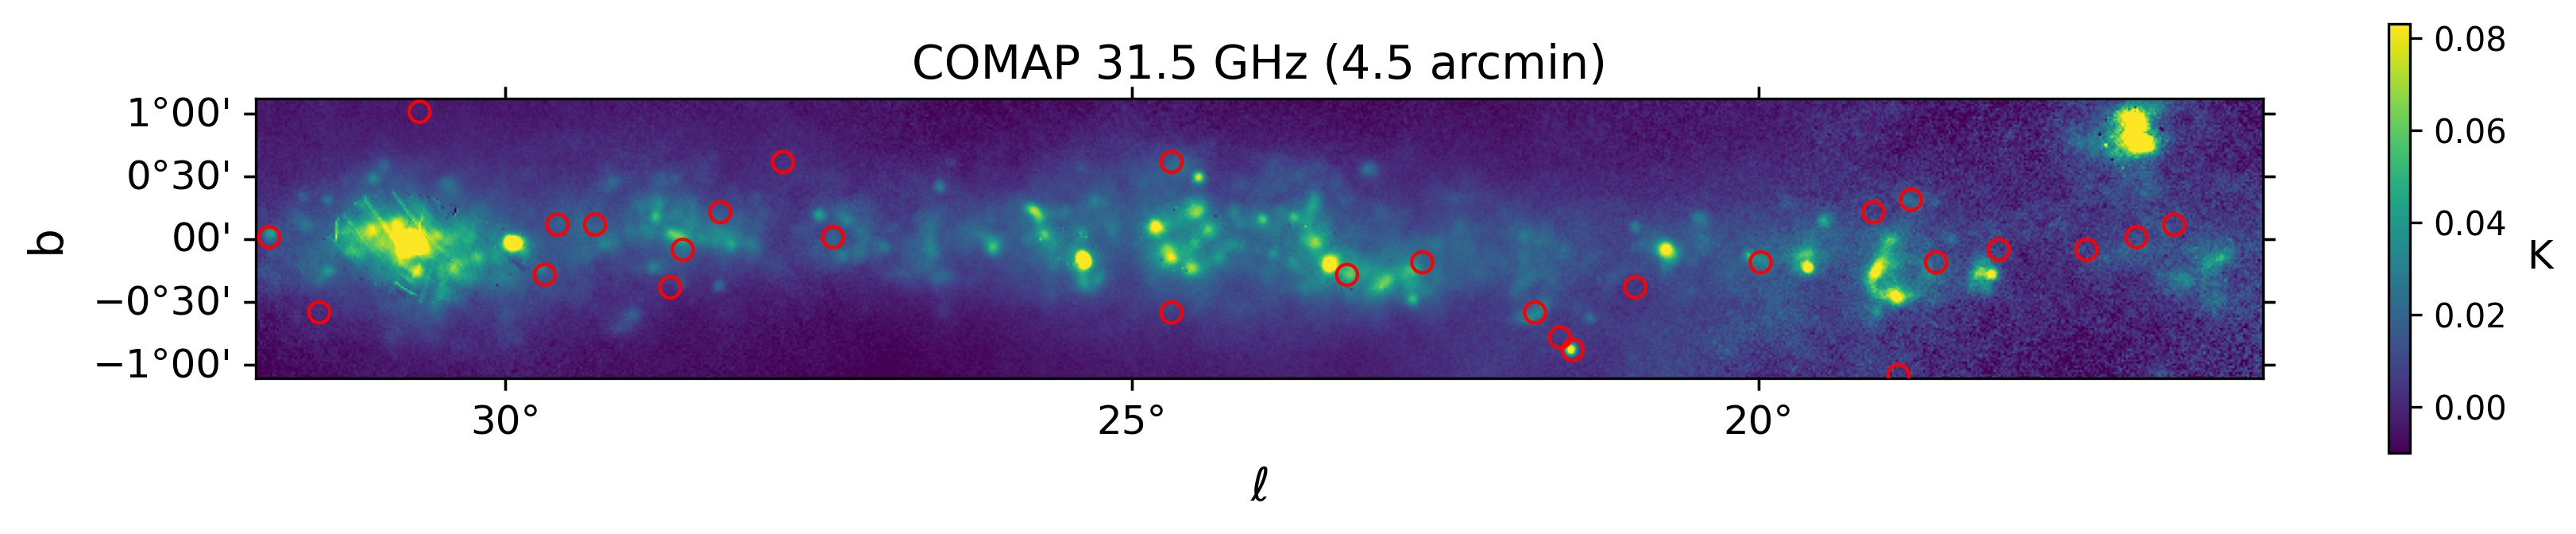

In [15]:
# Frequencies in GHz
map_paths = {
    "comap_31.5": '/Users/user/phd/comap/comap_maps/comap_160625_band05_band05_feed01-02-03-04-05-06-07-08-09-11-12-13-14-15-16-17-18-19.fits'
}

map_titles = ['COMAP 31.5 GHz (4.5 arcmin)']

# Initialize dictionaries for FITS, data, headers, and WCS
fits_data = {}
map_data = {}
headers = {}
wcs_objects = {}

# Load all FITS files
for key, path in map_paths.items():
    hdul = fits.open(path)
    fits_data[key] = hdul
    map_data[key] = hdul[0].data
    headers[key] = hdul[0].header
    wcs_objects[key] = WCS(headers[key])

# Cutout region
lat_max = 1.1
lat_min = -1.1
long_max = 32
long_min = 16
step = 0.0166666  # pixel size in degrees

map_names = list(map_data.keys()) 

fig, axs = plt.subplots(len(map_names), 1, figsize=(13, 2 * len(map_names)),
                        dpi=300, subplot_kw={'projection': wcs_objects[map_names[0]]}, squeeze=False)

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif') 

n = 0

for idx, map_name in enumerate(map_names):
    header = headers[map_name].copy()
    wcs = wcs_objects[map_name].copy()
    data = map_data[map_name].copy()

    # Indices for cutout
    start_row = int(header['CRPIX2'] + lat_min / step)
    end_row   = int(header['CRPIX2'] + lat_max / step)
    start_col = int(header['CRPIX1'] + (header['CRVAL1'] - long_max) / step)
    end_col   = int(header['CRPIX1'] + (header['CRVAL1'] - long_min) / step)

    snr_l_here = header['CRPIX1'] + (header['CRVAL1'] - snr_l) / step - start_col
    snr_b_here = header['CRPIX2'] + snr_b / step - start_row

    # Safety check for invalid indices
    nrows, ncols = data.shape
    start_row = max(0, min(nrows - 1, start_row))
    end_row   = max(0, min(nrows - 1, end_row))
    start_col = max(0, min(ncols - 1, start_col))
    end_col   = max(0, min(ncols - 1, end_col))

    # Extract and process submap
    submap = data[start_row:end_row + 1, start_col:end_col + 1].copy()
    submap[submap == 0] = np.nan

    # Update WCS
    wcs.wcs.crpix[0] -= start_col
    wcs.wcs.crpix[1] -= start_row

    # Determine color limits (optional: using percentiles to exclude outliers)
    vmin = -0.01 #np.nanpercentile(submap, 0.)
    vmax = np.nanpercentile(submap, 99.5)
    print(f"Map: {map_name}, vmin: {vmin}, vmax: {vmax}")

    levels = np.logspace(np.log10(0.01), np.log10(0.64), 7)
    
    # Plot
    ax = axs[idx, 0]
    im = ax.imshow(submap, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    contour_colors = plt.cm.Greys(np.linspace(0.0, 1.0, len(levels)))
    # for lev, col in zip(levels, contour_colors):
    #     ax.contour(submap_co_5, levels=[lev], colors=[col], linewidths=0.75)
    ax.scatter(snr_l_here, snr_b_here, facecolors='none', edgecolors='red', s=40, linewidths=1,
               label='SNR Sources', zorder=5)
    ax.set_title(map_titles[n], fontsize=14)
    n += 1
    ax.set_xlabel(r'$\ell$', fontsize=14)
    ax.set_ylabel('b', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Add individual colorbar to the right of each subplot
    cbar = fig.colorbar(im, orientation='vertical')
    cbar.ax.set_ylabel('K', rotation=0, labelpad=10, fontsize=12)

# Adjust general layout
fig.subplots_adjust(left=0.07, right=0.88, top=0.95, bottom=0.05, hspace=0.4)

# Save if needed
# plt.savefig('/Users/user/Desktop/comap_multi_indep.png', bbox_inches='tight', dpi=300)

plt.show()

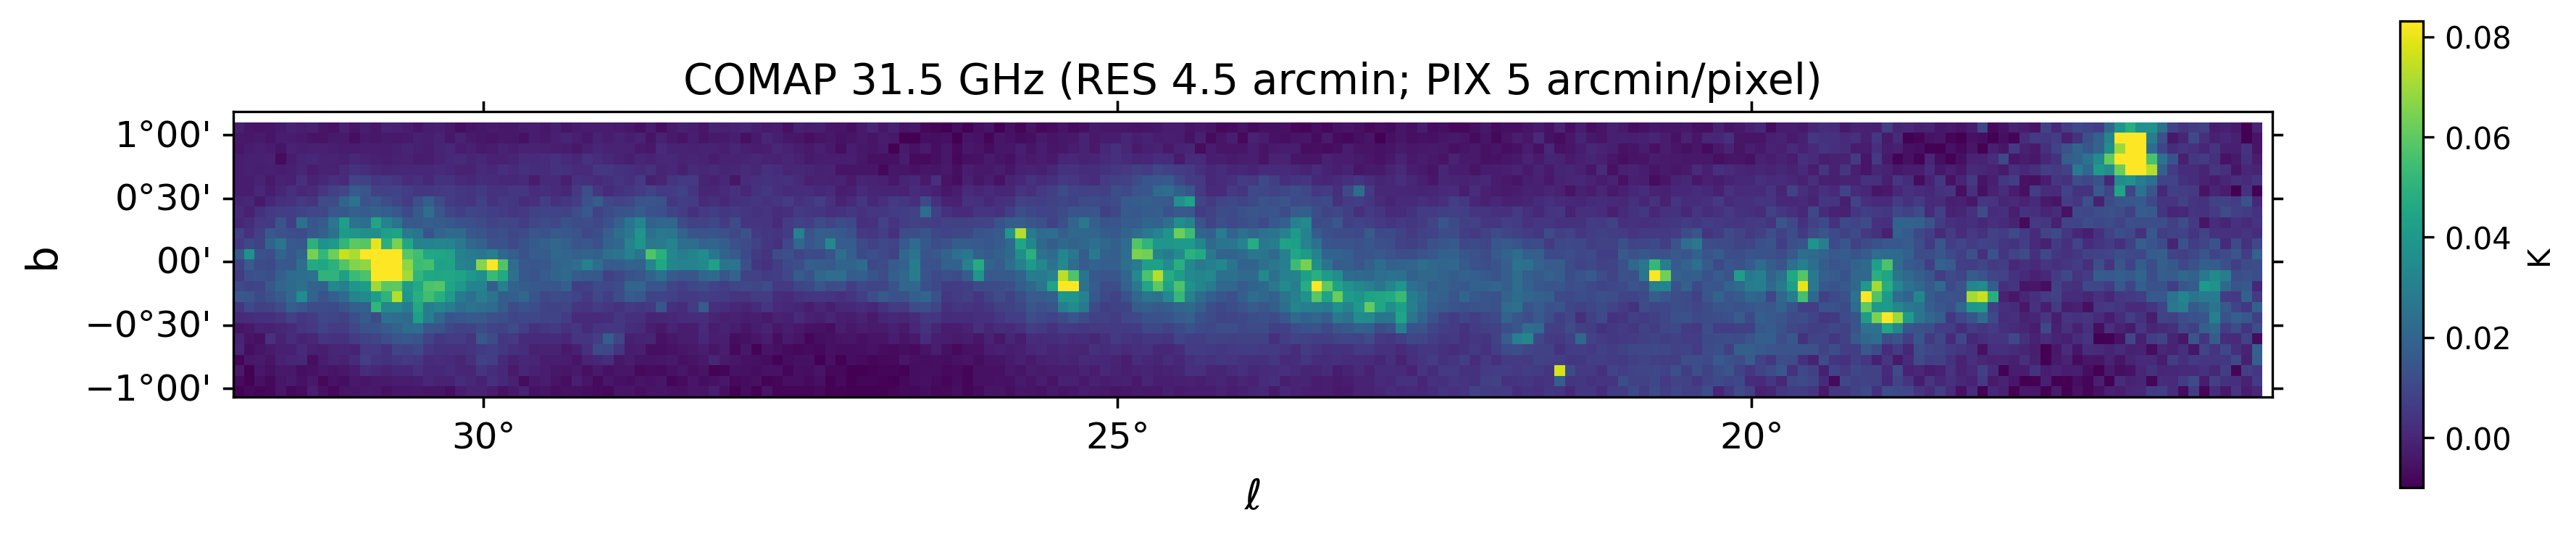

In [43]:
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from astropy.wcs.utils import proj_plane_pixel_scales
import numpy as np
import matplotlib.pyplot as plt

# Frequency in GHz
map_path = '/Users/user/phd/comap/comap_maps/comap_160625_band05_band05_feed01-02-03-04-05-06-07-08-09-11-12-13-14-15-16-17-18-19.fits'
map_title = 'COMAP 31.5 GHz (RES 4.5 arcmin; PIX 5 arcmin/pixel)'

# Open FITS file
hdul = fits.open(map_path)
data = hdul[0].data
header = hdul[0].header
wcs = WCS(header)

# Define cutout region
lat_max = 1.1
lat_min = -1.1
long_max = 32
long_min = 16
step = 0.0166666  # pixel size in degrees

# Indices for cutout
start_row = int(header['CRPIX2'] + lat_min / step)
end_row   = int(header['CRPIX2'] + lat_max / step)
start_col = int(header['CRPIX1'] + (header['CRVAL1'] - long_max) / step)
end_col   = int(header['CRPIX1'] + (header['CRVAL1'] - long_min) / step)

# Safety check for valid indices
nrows, ncols = data.shape
start_row = max(0, min(nrows - 1, start_row))
end_row   = max(0, min(nrows - 1, end_row))
start_col = max(0, min(ncols - 1, start_col))
end_col   = max(0, min(ncols - 1, end_col))

# Extract submap
submap = data[start_row:end_row+1, start_col:end_col+1].copy()
submap[submap == 0] = np.nan

# Update WCS for the submap
wcs.wcs.crpix[0] -= start_col
wcs.wcs.crpix[1] -= start_row

# Center of the submap
shape_out = submap.shape
center_pix = np.array(shape_out) / 2
center_lon, center_lat = wcs.pixel_to_world_values(center_pix[1], center_pix[0])

# Desired pixel scale in degrees (5 arcmin/pixel)
pixel_scale_deg = 5 / 60

# Angular size of the original submap in degrees
orig_scales = proj_plane_pixel_scales(wcs)
size_deg_x = orig_scales[0] * shape_out[1]
size_deg_y = orig_scales[1] * shape_out[0]

# New shape in pixels
new_shape_x = int(np.ceil(size_deg_x / pixel_scale_deg))
new_shape_y = int(np.ceil(size_deg_y / pixel_scale_deg))
new_shape = (new_shape_y, new_shape_x)

# Create new WCS
new_wcs = WCS(naxis=2)
new_wcs.wcs.crval = [center_lon, center_lat]
new_wcs.wcs.crpix = [new_shape[1]/2, new_shape[0]/2]
new_wcs.wcs.ctype = list(wcs.wcs.ctype)
new_wcs.wcs.cdelt = np.array([-pixel_scale_deg, pixel_scale_deg])

# Reproject submap to new WCS
submap_reprojected, footprint = reproject_interp(
    (submap, wcs),
    new_wcs,
    shape_out=new_shape
)

# Color limits for plotting
vmin = -0.01
vmax = np.nanpercentile(submap, 99.5)

# Plot the submap
plt.figure(figsize=(13, 3), dpi=300)
ax = plt.subplot(projection=new_wcs)
im = ax.imshow(submap_reprojected, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_title(map_title, fontsize=14)
ax.set_xlabel(r'$\ell$', fontsize=14)
ax.set_ylabel('b', fontsize=14)
ax.tick_params(labelsize=12)
plt.colorbar(im, ax=ax, label='K')
plt.tight_layout()
plt.show()

vmin: -0.009442893788218498, vmax: 0.07366197057068258


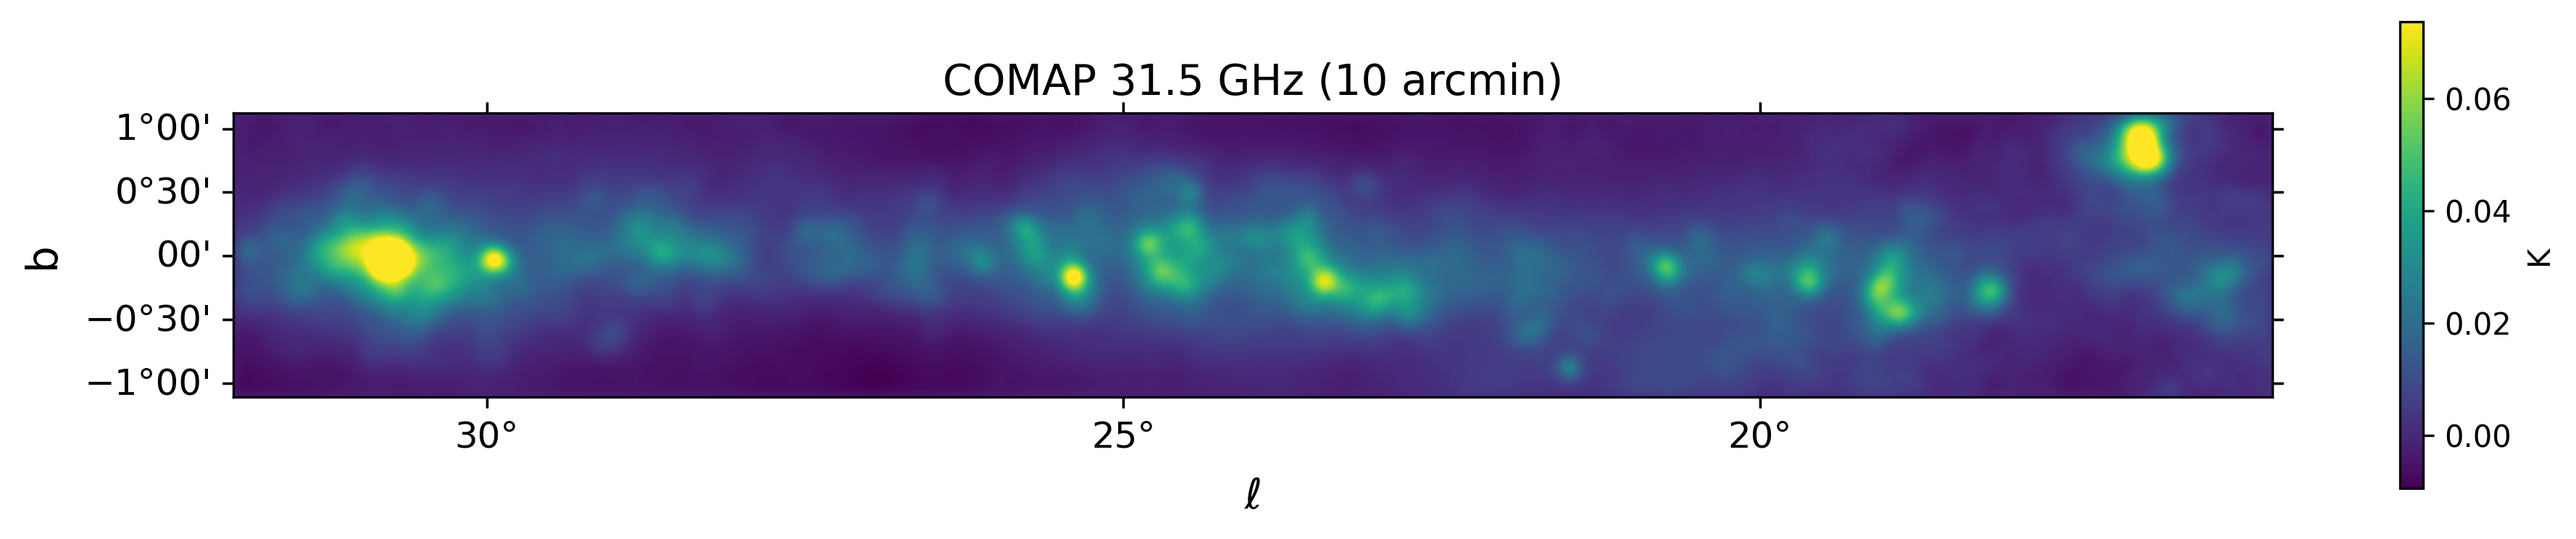

In [45]:
# Frequency in GHz
map_path = '/Users/user/phd/comap/comap_maps/comap_160625_band05_band05_feed01-02-03-04-05-06-07-08-09-11-12-13-14-15-16-17-18-19.fits'
map_title = 'COMAP 31.5 GHz (10 arcmin)'

# Open FITS
hdul = fits.open(map_path)
data = hdul[0].data
header = hdul[0].header
wcs = WCS(header)

# Cutout region
lat_max = 1.1
lat_min = -1.1
long_max = 32
long_min = 16
step = 0.0166666  # pixel size in degrees

# Cutout indices
nrows, ncols = data.shape
start_row = int(header['CRPIX2'] + lat_min / step)
end_row   = int(header['CRPIX2'] + lat_max / step)
start_col = int(header['CRPIX1'] + (header['CRVAL1'] - long_max) / step)
end_col   = int(header['CRPIX1'] + (header['CRVAL1'] - long_min) / step)

# Safety check
start_row = max(0, min(nrows - 1, start_row))
end_row   = max(0, min(nrows - 1, end_row))
start_col = max(0, min(ncols - 1, start_col))
end_col   = max(0, min(ncols - 1, end_col))

# Extract submap
submap = data[start_row:end_row + 1, start_col:end_col + 1].copy()
submap[submap == 0] = np.nan

# Smooth map to 10 arcmin resolution
fwhm_initial = 4.5  # arcmin
fwhm_final = 10.0   # arcmin

pixel_size_deg = abs(header['CDELT1'])
pixel_size_arcmin = pixel_size_deg * 60

sigma_pix = np.sqrt(fwhm_final**2 - fwhm_initial**2) / (2 * np.sqrt(2 * np.log(2)) * pixel_size_arcmin)
kernel = Gaussian2DKernel(x_stddev=sigma_pix)
submap_smoothed = convolve(submap, kernel, preserve_nan=True)

# Update WCS for submap
wcs.wcs.crpix[0] -= start_col
wcs.wcs.crpix[1] -= start_row

# Determine color limits
vmin = np.nanpercentile(submap_smoothed, 0.)
vmax = np.nanpercentile(submap_smoothed, 99.5)
print(f"vmin: {vmin}, vmax: {vmax}")

# Plot
plt.figure(figsize=(13, 3), dpi=300)
ax = plt.subplot(projection=wcs)
im = ax.imshow(submap_smoothed, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
# Optional contours
# levels = np.logspace(np.log10(0.01), np.log10(0.64), 7)
# for lev in levels:
#     ax.contour(submap_smoothed, levels=[lev], colors='gray', linewidths=0.75)

# Optional SNR markers (define snr_l and snr_b if needed)
# ax.scatter(snr_l_here, snr_b_here, facecolors='none', edgecolors='red', s=40, linewidths=1, zorder=5)

ax.set_title(map_title, fontsize=14)
ax.set_xlabel(r'$\ell$', fontsize=14)
ax.set_ylabel('b', fontsize=14)
ax.tick_params(labelsize=12)
plt.colorbar(im, ax=ax, label='K')
plt.tight_layout()
plt.show()


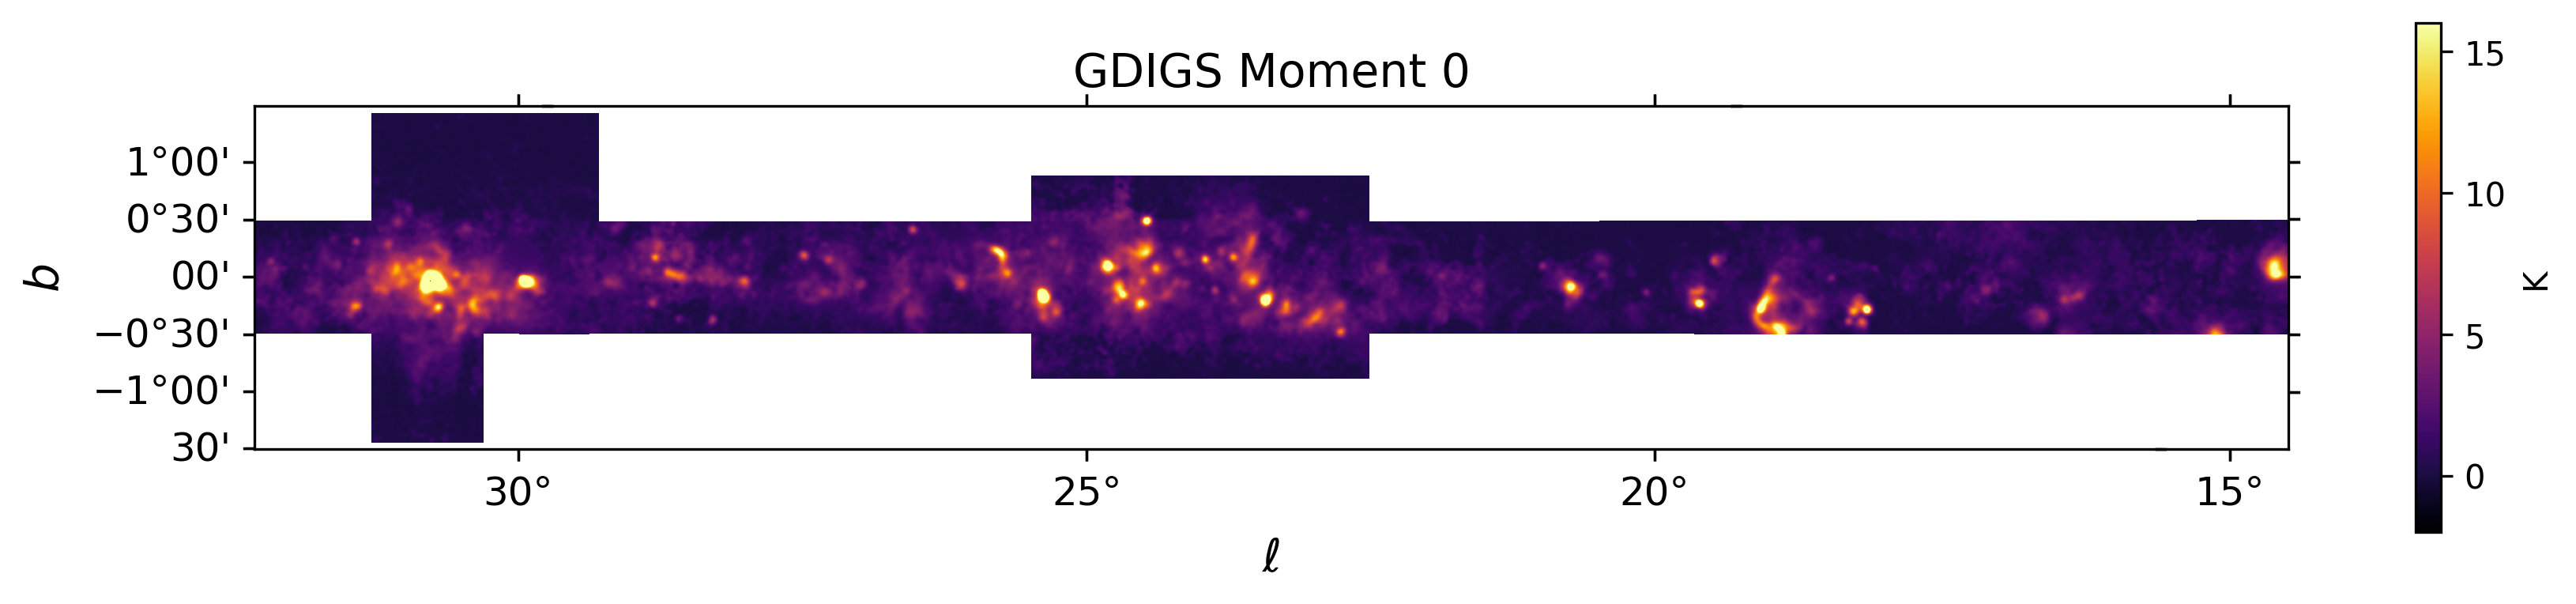

In [35]:
# Paths to the 4 maps
paths = [
    '/Users/user/phd/comap/GDIGS/Alpha/GDIGS_G017.50+00.00_halpha_2pol_average_moment0.fits',
    '/Users/user/phd/comap/GDIGS/Alpha/GDIGS_G022.50+00.00_halpha_2pol_average_moment0.fits',
    '/Users/user/phd/comap/GDIGS/Alpha/GDIGS_G027.25+00.00_halpha_2pol_average_moment0.fits',
    '/Users/user/phd/comap/GDIGS/Alpha/GDIGS_G030.80+00.00_halpha_2pol_average_moment0.fits',
]

# Open the HDUs
hdus = [fits.open(path)[0] for path in paths]

# Convert to a list of (array, WCS)
input_hdus = [(hdu.data, WCS(hdu.header)) for hdu in hdus]

# Determine the optimal WCS and output shape for the mosaic
mosaic_wcs, shape_out = find_optimal_celestial_wcs(input_hdus)

# Reproject and combine the maps
mosaic, footprint = reproject_and_coadd(
    input_hdus,
    output_projection=mosaic_wcs,
    shape_out=shape_out,
    reproject_function=reproject_interp,
    combine_function='mean'  # options: 'sum' or 'median'
)

# Plot the resulting mosaic
plt.figure(figsize=(12, 3), dpi=300)
ax = plt.subplot(projection=mosaic_wcs)
levels = [2, 4, 8, 16, 32]
#contours_mosaic = ax.contour(mosaic, levels=levels, colors='cyan', linewidths=0.4, transform=ax.get_transform(mosaic_wcs))
im = ax.imshow(mosaic, origin='lower', cmap='inferno', vmin=-2, vmax=16)
plt.title('GDIGS Moment 0', fontsize=14)
plt.xlabel(r'$\ell$', fontsize=14)
plt.ylabel(r'$b$', fontsize=14)
plt.tick_params(labelsize=12)
plt.colorbar(im, ax=ax, label='K')
plt.tight_layout()
plt.show()

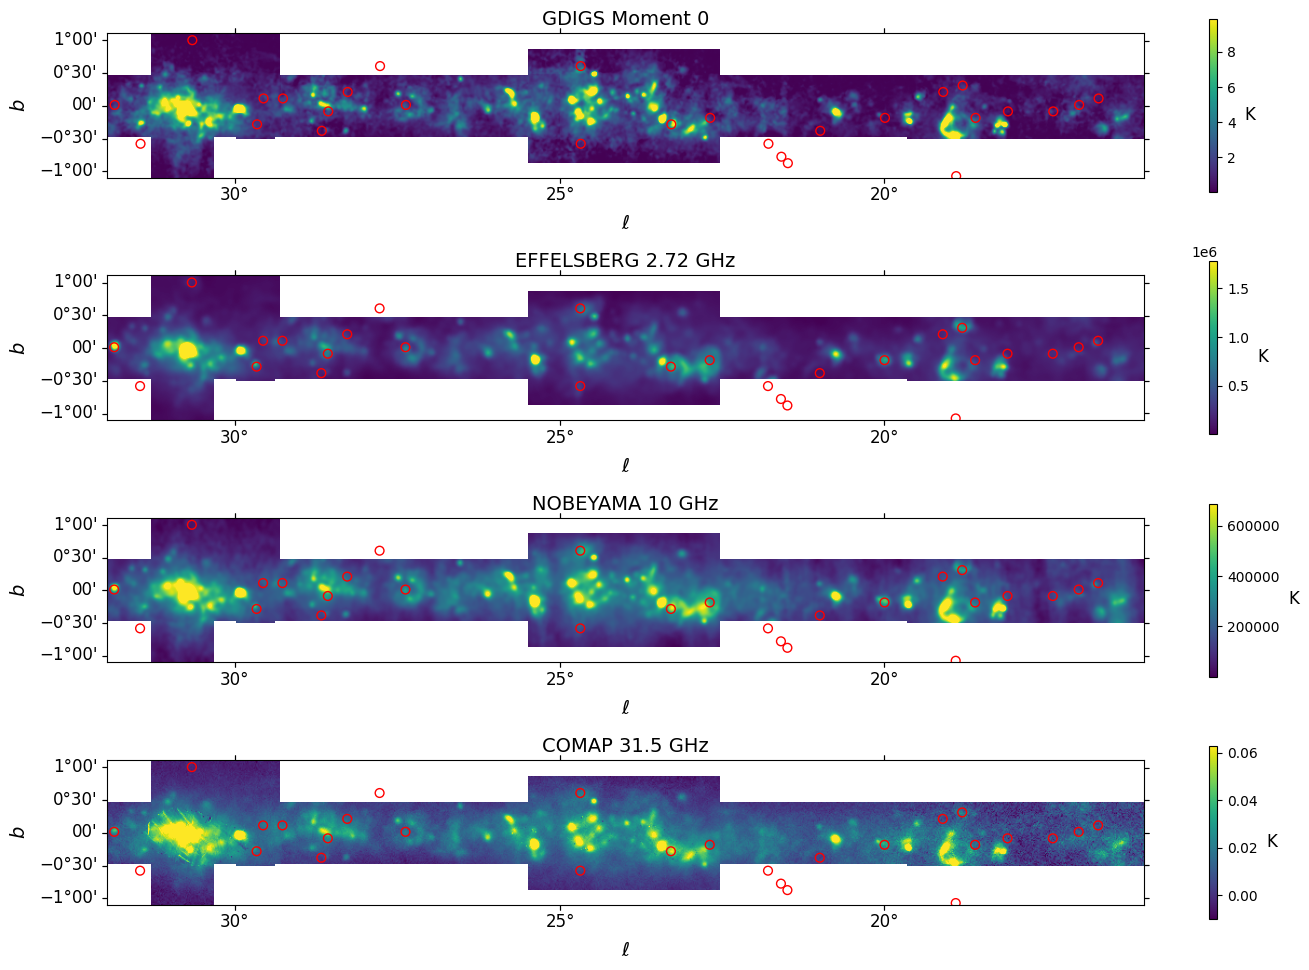

In [21]:
# Frequencies in GHz
map_paths = {
    "GDIGS": '/Users/user/phd/comap/GDIGS/gdigs_mosaic_1arcmin.fits',
    "effel_2.72": '/Users/user/phd/hoerning24_comap_science/tjrennier_gal_maps/EFFELSBERG-2.7272727272727275GHz-5.0amin.fits',
    "nobey_10.0": '/Users/user/phd/hoerning24_comap_science/tjrennier_gal_maps/NOBEYAMA-10.0GHz-5.0amin.fits',
    # "comap_26.5": '/Users/user/phd/comap/comap_maps/comap_160625_band00_band00_feed01-02-03-04-05-06-07-08-09-11-12-13-14-15-16-17-18-19.fits',
    # "comap_27.5": '/Users/user/phd/comap/comap_maps/comap_160625_band01_band01_feed01-02-03-04-05-06-07-08-09-11-12-13-14-15-16-17-18-19.fits',
    # "comap_28.5": '/Users/user/phd/comap/comap_maps/comap_160625_band02_band02_feed01-02-03-04-05-06-07-08-09-11-12-13-14-15-16-17-18-19.fits',
    # "comap_29.5": '/Users/user/phd/comap/comap_maps/comap_160625_band03_band03_feed01-02-03-04-05-06-07-08-09-11-12-13-14-15-16-17-18-19.fits',
    # "comap_30.5": '/Users/user/phd/comap/comap_maps/comap_160625_band04_band04_feed01-02-03-04-05-06-07-08-09-11-12-13-14-15-16-17-18-19.fits',
    "comap_31.5": '/Users/user/phd/comap/comap_maps/comap_160625_band05_band05_feed01-02-03-04-05-06-07-08-09-11-12-13-14-15-16-17-18-19.fits',
    # "comap_32.5": '/Users/user/phd/comap/comap_maps/comap_160625_band06_band06_feed01-02-03-04-05-06-07-08-09-11-12-13-14-15-16-17-18-19.fits',
    # "comap_33.5": '/Users/user/phd/comap/comap_maps/comap_160625_band07_band07_feed01-02-03-04-05-06-07-08-09-11-12-13-14-15-16-17-18-19.fits', 
    # "planc_217": '/Users/user/phd/hoerning24_comap_science/tjrennier_gal_maps/PLANCK HFI-217.0GHz-5.0amin.fits',
    # "planc_353": '/Users/user/phd/hoerning24_comap_science/tjrennier_gal_maps/PLANCK HFI-353.0GHz-5.0amin.fits',
    # "planc_545": '/Users/user/phd/hoerning24_comap_science/tjrennier_gal_maps/PLANCK HFI-545.0GHz-5.0amin.fits',
    # "planc_857": '/Users/user/phd/hoerning24_comap_science/tjrennier_gal_maps/PLANCK HFI-857.0GHz-5.0amin.fits'
}

map_titles = [
    'GDIGS Moment 0',
    'EFFELSBERG 2.72 GHz', 
    'NOBEYAMA 10 GHz', 
    # 'COMAP 26.5 GHz', 'COMAP 27.5 GHz', 'COMAP 28.5 GHz',
    # 'COMAP 29.5 GHz', 'COMAP 30.5 GHz',
    'COMAP 31.5 GHz', 
    # 'COMAP 32.5 GHz', 'COMAP 33.5 GHz', 
    'PLANCK 217 GHz', 
    'PLANCK 353 GHz', 
    'PLANCK 545 GHz', 
    'PLANCK 857 GHz'
]

freqs = np.array([0.0, 2.72, 10.0, 31.5, 217.0, 353.0, 545.0, 857.0])

# Initialize dictionaries for FITS, data, headers, and WCS
fits_data = {}
map_data = {}
headers = {}
wcs_objects = {}
map_data_slice = {}
wcs_objects_slice = {}

# Load all files
for key, path in map_paths.items():
    hdul = fits.open(path)
    fits_data[key] = hdul
    map_data[key] = hdul[0].data
    headers[key] = hdul[0].header
    wcs_objects[key] = WCS(headers[key])

# Cutout region
lat_max = 1.1
lat_min = -1.1
long_max = 32
long_min = 16
step = 0.0166666  # pixel resolution

map_names = list(map_data.keys()) 

fig, axs = plt.subplots(len(map_names), 1, figsize=(16, 2.5 * len(map_names)),
                        dpi=100, subplot_kw={'projection': wcs_objects[map_names[0]]}, squeeze=False)

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif') 

n = 0

for idx, map_name in enumerate(map_names):
    header = headers[map_name].copy()
    wcs = wcs_objects[map_name].copy()
    data = map_data[map_name].copy()

    # Indices for cutout
    start_row = int(header['CRPIX2'] + lat_min / step)
    end_row   = int(header['CRPIX2'] + lat_max / step)
    start_col = int(header['CRPIX1'] + (header['CRVAL1'] - long_max) / step)
    end_col   = int(header['CRPIX1'] + (header['CRVAL1'] - long_min) / step)

    snr_l_here = header['CRPIX1'] + (header['CRVAL1'] - snr_l) / step - start_col
    snr_b_here = header['CRPIX2'] + snr_b / step - start_row

    # Safety check against invalid indices
    nrows, ncols = data.shape
    start_row = max(0, min(nrows - 1, start_row))
    end_row   = max(0, min(nrows - 1, end_row))
    start_col = max(0, min(ncols - 1, start_col))
    end_col   = max(0, min(ncols - 1, end_col))

    # Extract and process submap
    submap = data[start_row:end_row + 1, start_col:end_col + 1].copy()
    submap[submap == 0] = np.nan

    if map_name == 'GDIGS':
        map_gids = submap.copy()

    submap[np.isnan(map_gids)] = np.nan

    # Update WCS
    wcs.wcs.crpix[0] -= start_col
    wcs.wcs.crpix[1] -= start_row

    map_data_slice[map_name] = submap
    wcs_objects_slice[map_name] = wcs

    # Determine color limits (optional: here using percentiles to exclude outliers)
    vmin = np.nanpercentile(submap, 0.05)
    vmax = np.nanpercentile(submap, 98.5)
    
    levels = np.logspace(np.log10(0.01), np.log10(0.64), 14)
    
    # Scaling factor for each map (adjust manually per dataset)
    factor = [0, 187465.741119, 72713.425379, 0.006657, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    factor = [0, 0.9e5, 6e4, 0.004, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    map_factor = [1, 0.67, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    factor = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    # factor = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # alternative test
    
    # Plot
    ax = axs[idx, 0]
    im = ax.imshow(map_factor[n] * submap - map_gids * factor[n], origin='lower',
                   cmap='viridis', vmin=vmin, vmax=vmax)
    # im = ax.imshow(submap, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    contour_colors = plt.cm.Greys(np.linspace(0.0, 1.0, len(levels)))
    # for lev, col in zip(levels, contour_colors):
    #     ax.contour(submap, levels=[lev], colors=[col], linewidths=0.75)
    ax.scatter(snr_l_here, snr_b_here, facecolors='none', edgecolors='red',
               s=40, linewidths=1, label='SNR Sources', zorder=5)
    ax.set_title(map_titles[n], fontsize=14)
    n += 1
    ax.set_xlabel(r'$\ell$', fontsize=14)
    ax.set_ylabel(r'$b$', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Add an individual colorbar to the right of each subplot
    cbar = fig.colorbar(im, orientation='vertical')
    cbar.ax.set_ylabel('K', rotation=0, labelpad=10, fontsize=12)

# Adjust overall layout
fig.subplots_adjust(left=0.07, right=0.88, top=0.95, bottom=0.05, hspace=0.4)

# Save if needed
# plt.savefig('/Users/user/Desktop/comap_multi_indep.png', bbox_inches='tight', dpi=300)

plt.show()

# Effelsberg scaling factor ~0.67


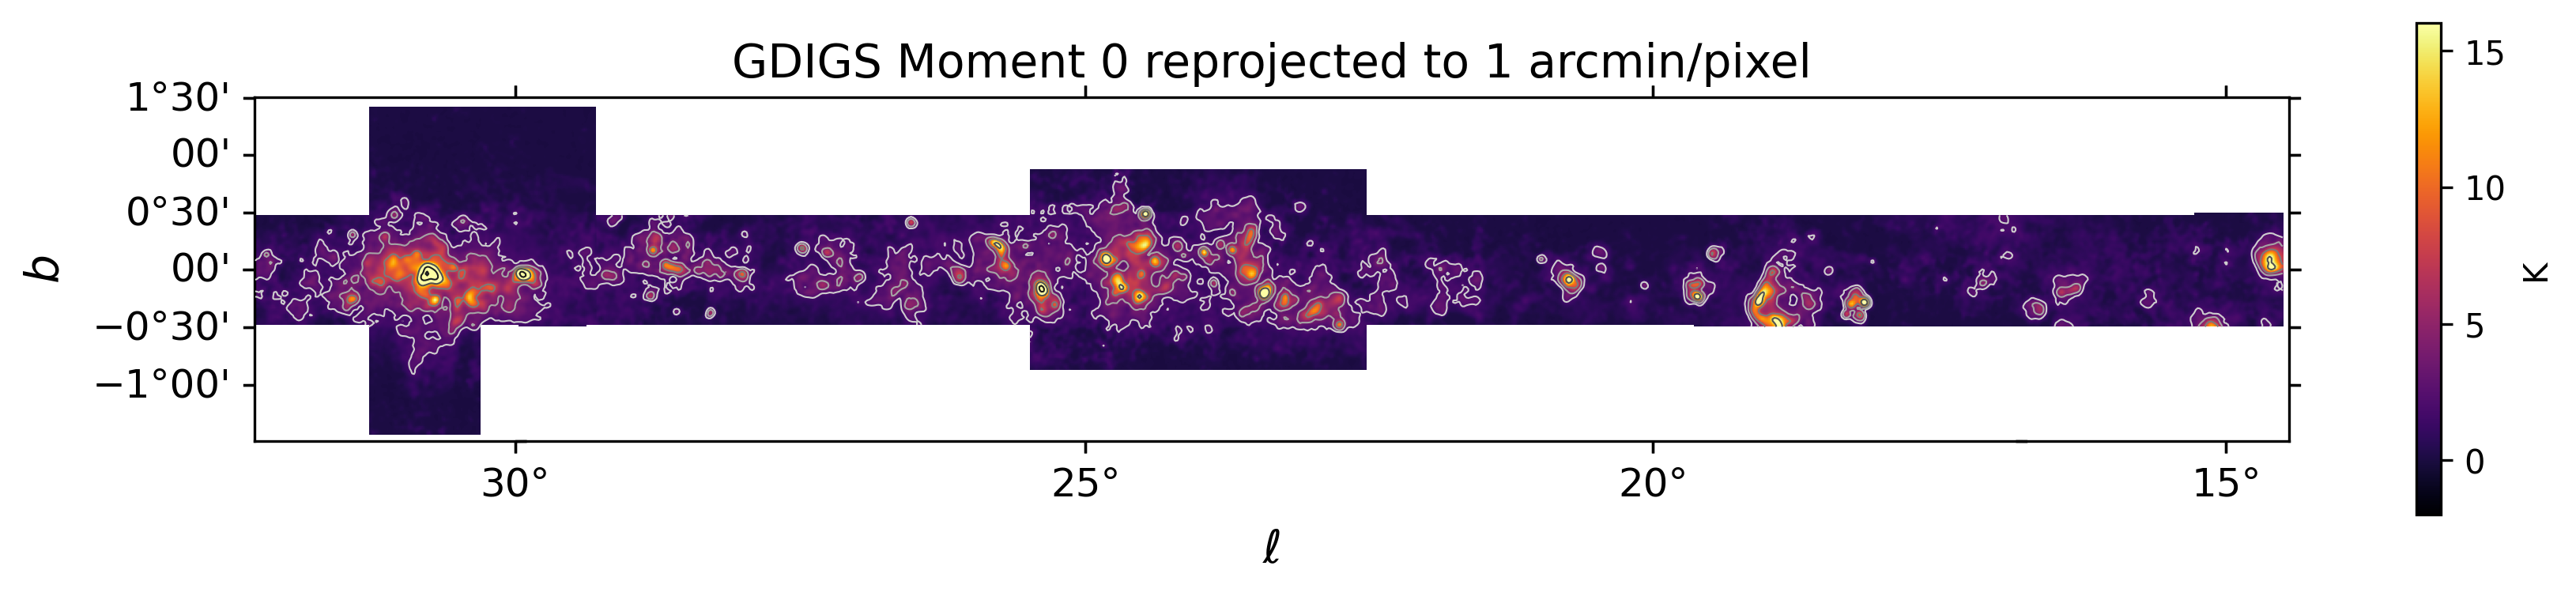

In [50]:
# Paths to the 4 maps
paths = [
    '/Users/user/phd/comap/GDIGS/Alpha/GDIGS_G017.50+00.00_halpha_2pol_average_moment0.fits',
    '/Users/user/phd/comap/GDIGS/Alpha/GDIGS_G022.50+00.00_halpha_2pol_average_moment0.fits',
    '/Users/user/phd/comap/GDIGS/Alpha/GDIGS_G027.25+00.00_halpha_2pol_average_moment0.fits',
    '/Users/user/phd/comap/GDIGS/Alpha/GDIGS_G030.80+00.00_halpha_2pol_average_moment0.fits',
]

# Open the HDUs
hdus = [fits.open(path)[0] for path in paths]

# Convert to a list of (array, WCS)
input_hdus = [(hdu.data, WCS(hdu.header)) for hdu in hdus]

# Determine optimal WCS and mosaic shape
mosaic_wcs, shape_out = find_optimal_celestial_wcs(input_hdus)

# Reproject and combine the maps
mosaic, footprint = reproject_and_coadd(
    input_hdus,
    output_projection=mosaic_wcs,
    shape_out=shape_out,
    reproject_function=reproject_interp,
    combine_function='mean'  # can also use 'sum' or 'median'
)

# Get the center of the original image (mosaic_wcs)
center_pix = np.array(shape_out) / 2
center_lon, center_lat = mosaic_wcs.pixel_to_world_values(center_pix[1], center_pix[0])

# Pixel scale in degrees (1 arcmin = 1/60 deg)
pixel_scale_deg = 1 / 60  # degrees per pixel

# Determine angular size of the original image (in degrees)
orig_scales = proj_plane_pixel_scales(mosaic_wcs)  # degrees/pixel in x and y
size_deg_x = orig_scales[0] * shape_out[1]
size_deg_y = orig_scales[1] * shape_out[0]

# Compute new shape in pixels for the same area with 1 arcmin/pixel
new_shape_x = int(np.ceil(size_deg_x / pixel_scale_deg))
new_shape_y = int(np.ceil(size_deg_y / pixel_scale_deg))
new_shape = (new_shape_y, new_shape_x)

# Create a new WCS
new_wcs = WCS(naxis=2)
new_wcs.wcs.crval = [center_lon, center_lat]              # center of the image in degrees
new_wcs.wcs.crpix = [new_shape[1] / 2, new_shape[0] / 2]  # center pixel for new shape
new_wcs.wcs.ctype = list(mosaic_wcs.wcs.ctype)           # keep original projection
new_wcs.wcs.cdelt = np.array([-pixel_scale_deg, pixel_scale_deg])  # pixel scale in degrees

# Reproject the mosaic to the new WCS
mosaic_reprojected, footprint = reproject_interp(
    (mosaic, mosaic_wcs),
    new_wcs,
    shape_out=new_shape
)

# Plot
plt.figure(figsize=(12, 3), dpi=300)
ax = plt.subplot(projection=new_wcs)

levels = [2, 4, 8, 16, 32]
contour_colors = plt.cm.Greys(np.linspace(0.3, 0.9, len(levels)))  # shades from light to dark gray
for lev, col in zip(levels, contour_colors):
    ax.contour(mosaic_reprojected, levels=[lev], colors=[col], linewidths=0.5)

im = ax.imshow(mosaic_reprojected, origin='lower', cmap='inferno', vmin=-2, vmax=16)
plt.title('GDIGS Moment 0 reprojected to 1 arcmin/pixel', fontsize=14)
plt.xlabel(r'$\ell$', fontsize=14)
plt.ylabel(r'$b$', fontsize=14)
plt.tick_params(labelsize=12)
plt.colorbar(im, ax=ax, label='K')
plt.tight_layout()
plt.show()

# Convert the WCS to a FITS header
new_header = new_wcs.to_header()

# Create the HDU with the data and WCS header
hdu = fits.PrimaryHDU(data=mosaic_reprojected, header=new_header)

# (Optional) Update the unit if known
hdu.header['BUNIT'] = 'K'  # or the correct unit of your data

# Save the FITS
hdu.writeto('/Users/user/phd/comap/GDIGS/gdigs_mosaic_1arcmin.fits', overwrite=True)
